# RASCIL notebook for pipeline processing of eMERLIN data

In [1]:
import json

import time

from erp.functions.support import start_eMRP_dict, get_logger, get_defaults, find_run_steps
from erp.functions.imaging_steps import *

from rascil.workflows.rsexecute.execution_support import rsexecute

current_version = "0.0.1"

# Define the steps we want to execute

In [2]:
run_steps = ["load_ms", "average_channels", "convert_stokesI", "create_images",
"weight", "ical", "write_images", "write_gaintables", "write_ms"]

# Initialize eMRP dictionary:
eMRP = start_eMRP_dict('./')

logger = get_logger()

start_epoch = time.asctime()
logger.info("eMERLIN RASCIL imaging pipeline, started at  %s" % start_epoch)

2020-03-02 16:32:20 | INFO | eMERLIN RASCIL imaging pipeline, started at  Mon Mar  2 16:32:20 2020


In [3]:
defaults_file = 'default_params.json'
logger.info('Loading default parameters from {0}:'.format(defaults_file))
eMRP['defaults'] = json.loads(open(defaults_file).read())

# Steps to run:
eMRP['input_steps'] = find_run_steps(eMRP, run_steps, skip_steps=[])

# Pipeline processes, inputs are read from the inputs dictionary

eMRP = get_defaults(eMRP)

2020-03-02 16:32:20 | INFO | Loading default parameters from default_params.json:
2020-03-02 16:32:20 | INFO | Step selection
2020-03-02 16:32:20 | INFO | run_steps : ['load_ms', 'average_channels', 'convert_stokesI', 'create_images', 'weight', 'ical', 'write_images', 'write_gaintables', 'write_ms']
2020-03-02 16:32:20 | INFO | skip_steps: []
2020-03-02 16:32:20 | INFO | Sorted list of steps to execute:
2020-03-02 16:32:20 | INFO | initialize_pipeline: 0
2020-03-02 16:32:20 | INFO | list_ms         : 0
2020-03-02 16:32:20 | INFO | load_ms         : 1
2020-03-02 16:32:20 | INFO | flag            : 0
2020-03-02 16:32:20 | INFO | plot_vis        : 0
2020-03-02 16:32:20 | INFO | average_channels: 1
2020-03-02 16:32:20 | INFO | get_advice      : 0
2020-03-02 16:32:20 | INFO | convert_stokesI : 1
2020-03-02 16:32:20 | INFO | create_images   : 1
2020-03-02 16:32:20 | INFO | weight          : 1
2020-03-02 16:32:20 | INFO | cip             : 0
2020-03-02 16:32:20 | INFO | ical            : 1
20

In [4]:
initialize_pipeline(eMRP, get_logger=get_logger)

2020-03-02 16:32:20 | INFO | Distributed processing using Dask


In [5]:
bvis_list = None
if eMRP['input_steps']['list_ms'] > 0:
    list_ms(eMRP)

In [6]:
if eMRP['input_steps']['load_ms'] > 0:
    bvis_list = load_ms(eMRP)

2020-03-02 16:32:23 | INFO | Loading Measurement Set /Users/timcornwell/Code/eMERLIN_RASCIL_pipeline/data/3C277.1_avg.ms


In [7]:
if eMRP['input_steps']['flag'] > 0:
    bvis_list = flag(bvis_list, eMRP)

In [8]:
if eMRP['input_steps']['average_channels'] > 0:
    bvis_list = average_channels(bvis_list, eMRP)

2020-03-02 16:32:23 | INFO | Averaging by 32 channels within spectral windows


In [9]:
if eMRP['input_steps']['plot_vis'] > 0:
    plot_vis(bvis_list, eMRP)

In [10]:
if eMRP['input_steps']['convert_stokesI'] > 0:
    bvis_list = convert_stokesI(bvis_list, eMRP)

2020-03-02 16:32:23 | INFO | Converting to stokesI visibility


In [11]:
if eMRP['input_steps']['get_advice'] > 0:
    advice = get_advice(bvis_list, eMRP)

In [12]:
model_list = list()
if eMRP['input_steps']['create_images'] > 0:
    model_list = create_images(bvis_list, eMRP)

2020-03-02 16:32:23 | INFO | Creating template images


In [13]:
if eMRP['input_steps']['weight'] > 0:
    bvis_list = weight(bvis_list, model_list, eMRP)

2020-03-02 16:32:23 | INFO | Applying uniform weighting


In [14]:
if eMRP['input_steps']['cip'] > 0:
    results = cip(bvis_list, model_list, eMRP)
    results = rsexecute.compute(results, sync=True)
    if eMRP['input_steps']['write_images'] > 0:
        write_images(eMRP, 'cip', results)

2020-03-02 16:32:23 | INFO | Processing with RASCIL ICAL pipeline
2020-03-02 16:34:27 | INFO | Forming 1 moment images from 16 spws
2020-03-02 16:34:27 | INFO | Quality assessment:
	Origin: qa_image
	Context: RASCIL_1252+5634_ical_deconvolved_moment0
	Data:
		shape: '(1, 1, 256, 256)'
		max: '0.7648782764881338'
		min: '-0.06943882783954164'
		maxabs: '0.7648782764881338'
		rms: '0.005830346076416669'
		sum: '10.22596858282316'
		medianabs: '0.0'
		medianabsdevmedian: '0.0'
		median: '0.0'

2020-03-02 16:34:28 | INFO | Quality assessment:
	Origin: qa_image
	Context: RASCIL_1252+5634_ical_residual_moment0
	Data:
		shape: '(1, 1, 256, 256)'
		max: '0.05367181073061498'
		min: '-0.05346314966901634'
		maxabs: '0.05367181073061498'
		rms: '0.013114350893454068'
		sum: '-3.2617698787529528'
		medianabs: '0.007589139504194705'
		medianabsdevmedian: '0.007595184523745626'
		median: '-0.0001262545237227993'

2020-03-02 16:34:29 | INFO | Quality assessment:
	Origin: qa_image
	Context: RASCIL_12

<Figure size 432x288 with 0 Axes>

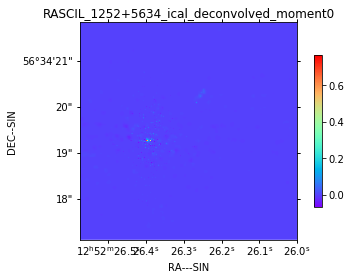

<Figure size 432x288 with 0 Axes>

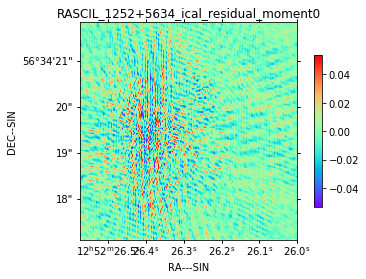

<Figure size 432x288 with 0 Axes>

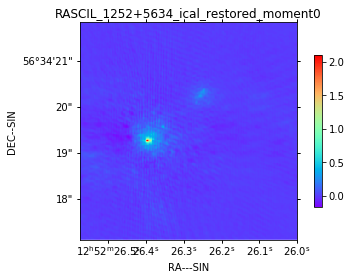

In [15]:
if eMRP['input_steps']['ical'] > 0:
    results = ical(bvis_list, model_list, eMRP)
    bvis_list, results = rsexecute.compute(results, sync=True)
    if eMRP['input_steps']['write_images'] > 0:
        write_images(eMRP, 'ical', results[0:3])
    if eMRP['input_steps']['write_gaintables'] > 0:
        write_gaintables(eMRP, 'ical', results[3])

2020-03-02 16:34:29 | INFO | Quality assessment:
	Origin: qa_gaintable
	Context: RASCIL_0_ical T
	Data:
		shape: '(2498, 6, 1, 1, 1)'
		maxabs-amp: '1.0000000000000002'
		minabs-amp: '0.9999999999999998'
		rms-amp: '8.343595510697557e-17'
		medianabs-amp: '1.0'
		maxabs-phase: '3.138224935174992'
		minabs-phase: '-3.140821803804571'
		rms-phase: '0.6749849831930772'
		medianabs-phase: '-7.260044705649971e-26'
		residual: '1.878936472026687'

2020-03-02 16:34:30 | INFO | Quality assessment:
	Origin: qa_gaintable
	Context: RASCIL_0_ical G
	Data:
		shape: '(25, 6, 1, 1, 1)'
		maxabs-amp: '2.3111275215041998'
		minabs-amp: '0.5327047034272364'
		rms-amp: '0.24422025589778'
		medianabs-amp: '1.0125718832973354'
		maxabs-phase: '2.3765619818474577'
		minabs-phase: '-1.3937998809945937'
		rms-phase: '0.5137485682152089'
		medianabs-phase: '-4.118653619039464e-24'
		residual: '0.25281951457778506'



<Figure size 432x288 with 0 Axes>

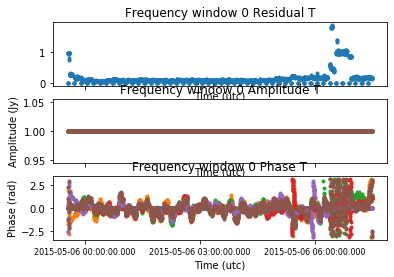

<Figure size 432x288 with 0 Axes>

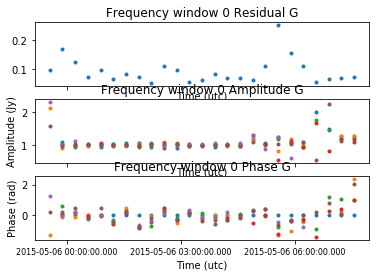

In [17]:
if eMRP['input_steps']['write_ms'] > 0:
    bvis_list = apply_calibration(results[3], bvis_list, eMRP)
    write_ms(bvis_list, eMRP)

stop_epoch = time.asctime()
logger.info("eMERLIN RASCIL imaging pipeline, started at  %s" % start_epoch)
logger.info("eMERLIN RASCIL imaging pipeline, finished at %s" % stop_epoch)





2020-03-02 16:34:35 | INFO | Combining across spectral windows
2020-03-02 16:34:35 | INFO | Writing Measurement Set /Users/timcornwell/Code/eMERLIN_RASCIL_pipeline/data/3C277.1C.avg.ms
2020-03-02 16:34:39 | INFO | eMERLIN RASCIL imaging pipeline, started at  Mon Mar  2 16:32:20 2020
2020-03-02 16:34:39 | INFO | eMERLIN RASCIL imaging pipeline, finished at Mon Mar  2 16:34:39 2020
